# Emotion Detection CNN (48x48 Grayscale Faces)

**Overview**  
I have a dataset containing **35,685 examples** of 48×48 pixel grayscale images of faces.  
These images are split into **train** and **test** sets, each containing subfolders for the 7 emotions:
- angry
- disgusted
- fearful
- happy
- neutral
- sad
- surprised

I will build a **Convolutional Neural Network (CNN)** to classify each image into one of these 7 emotions.

**Key Steps**:
1. **Data Loading & Preprocessing**: Read images from the folder structure, normalize pixel values, and apply data augmentation.
2. **CNN Model Building**: Construct a CNN with convolution, pooling, and dropout layers.
3. **Model Training**: Train the CNN on the training set, validate on the test set.
4. **Evaluation**: Plot learning curves, compute confusion matrix, classification report.
5. **CRISP-DM Log**: Document all changes and analysis throughout.


### 1. Importing Dependencies

**What I Did**:  
- Imported libraries for data manipulation (`numpy`, `pandas`), visualization (`matplotlib`, `seaborn`), 
  and machine learning (`tensorflow.keras`, `sklearn.metrics`).

**Why**:  
- These libraries provide essential functionalities like building CNN models, loading images from directories, and evaluating classification performance.


In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


### 2. Data Loading & Understanding

**Folder Structure**:
dataset/ 
├── train/ │
        ├── angry/ │ 
        ├── disgusted/ │
        ├── fearful/ │
        ├── happy/ │
        ├── neutral/ │ 
        ├── sad/ 
        │── surprised/ 
|── test/ 
        ├── angry/ 
        ├── disgusted/ 
        ├── fearful/ 
        ├── happy/ 
        ├── neutral/ 
        ├── sad/ 
        |── surprised/

**Notes**:
- Each subfolder corresponds to one emotion class.
- Images are 48×48 grayscale faces.
- I will use `ImageDataGenerator.flow_from_directory()` to load images and automatically assign labels based on subfolder names.

**Practical Impact**:
- Ensures a structured approach to data loading.
- Quick verification of how many images are in each class.


In [4]:
train_dir = 'train'
test_dir = 'test'

print("Train subfolders (classes):", os.listdir(train_dir))
print("Test subfolders (classes) :", os.listdir(test_dir))


Train subfolders (classes): ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Test subfolders (classes) : ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


### 3. Data Preprocessing & Augmentation

**What I Did**:
- Created an `ImageDataGenerator` for training with data augmentation: random rotation, shifting, horizontal flip.
- Created a simpler generator for testing (no augmentation, just rescaling).
- Chose `target_size=(48,48)` and `color_mode='grayscale'` to match the dataset specs.

**Why**:
- Data augmentation helps the model generalize better and reduce overfitting.
- Normalizing pixels by `1./255` scales them to [0,1].


In [5]:
batch_size = 64
img_size = (48, 48)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Print class indices for reference

print("Class Indices:", train_generator.class_indices)

Class Indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}



1. **Training & Test Counts**  
   - The training directory contains **28,709 images**, and the test directory has **7,178 images**.  
   - This confirms that our dataset is correctly split into a larger training set and a smaller test set for evaluation.

2. **Seven Emotion Classes**  
   - The 7 subfolders (emotions) in both `train` and `test` directories are recognized as:  
     `angry`, `disgusted`, `fearful`, `happy`, `neutral`, `sad`, `surprised`.  
   - The **class indices** shown here (`{'angry': 0, 'disgusted': 1, ...}`) are automatically assigned by Keras based on alphabetical order of the folder names. These mappings will be used when training and evaluating the CNN.

3. **Data Augmentation Confirmation**  
   - Although not explicitly listed in the output, the lines “Found X images belonging to Y classes” confirm that the `ImageDataGenerator` successfully read the images with our specified augmentation parameters (rotation, shift, horizontal flip) for the training set and simple rescaling for the test set.

Overall, this output verifies that the dataset is loaded properly and that each image is labeled according to the folder structure. 

### 4. CNN Model Building

**Architecture**:
- 3 Convolutional blocks, each with:
  - Conv2D → BatchNormalization → Conv2D → BatchNormalization → MaxPooling → Dropout
- Fully connected layers for classification into 7 classes.
- `ReLU` activations and `softmax` for the final layer.

**Reasoning**:
- 48×48 grayscale images are small, so a moderate number of filters is sufficient.
- BatchNormalization helps stabilize training; Dropout helps prevent overfitting.
- `adam` optimizer is a good default choice for many CNN tasks.

**Practical Impact**:
- A well-structured CNN that can learn complex facial features (eyes, mouth, expressions) effectively.


In [8]:
num_classes = 7  # 'angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'

model = models.Sequential()

# Block 1

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

C:\Users\91818\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Block 2

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

In [11]:
# Block 3

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

In [12]:
# Fully Connected

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 44, 44, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 422,375 (1.61 MB)

 Trainable params: 420,967 (1.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

1. **Layer-by-Layer Architecture**  
   - **Convolution + BatchNorm** layers extract spatial features from the 48×48 grayscale images.  
   - **MaxPooling2D** reduces spatial dimensions, allowing the network to learn abstract features at different scales.  
   - **Dropout** randomly deactivates neurons during training, preventing overfitting.  

2. **Final Dense Layers**  
   - After flattening the feature maps, a Dense layer with 256 neurons further processes the extracted features.  
   - Another BatchNormalization + Dropout is used before the **final 7-output Dense layer** with softmax activation (one neuron per emotion).

3. **Parameter Counts**  
   - **Total Params: 422,375**  
     - These are all the learnable weights in the network.  
   - **Trainable vs. Non-trainable**:  
     - **420,967 trainable** means those will be updated during backpropagation.  
     - **1,408 non-trainable** typically come from BatchNorm scaling/bias parameters that can be frozen or constraints that do not change with training.  

4. **Memory Footprint**  
   - The model size is roughly **1.61 MB** in terms of parameters.  
   - This is a moderate-sized CNN, suitable for 48×48 images, balancing complexity and efficiency.

Overall, the summary confirms that the **3-block CNN** is set up correctly, with BatchNormalization and Dropout layers to aid in stable training and reduce overfitting. The final layer has **7 outputs** corresponding to the 7 emotion classes.


### 5. Model Training

**What I Did**:
- Set `epochs=30` as a starting point.
- Trained using `train_generator`, validated on `test_generator`.

**Why**:
- 30 epochs is typically enough to see if the model converges or overfits on this dataset size.
- The test set helps monitor performance in real-time (though ideally, I'd have a separate validation set).

**Practical Impact**:
- The CNN learns from ~35k images (with augmentation), testing on unseen images in `test/`.


In [14]:
epochs = 30

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 407s 892ms/step - accuracy: 0.1961 - loss: 2.4963 - val_accuracy: 0.2615 - val_loss: 1.8173
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 143s 319ms/step - accuracy: 0.2842 - loss: 1.8124 - val_accuracy: 0.3835 - val_loss: 1.5771
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.3786 - loss: 1.5985 - val_accuracy: 0.4206 - val_loss: 1.4999
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.4387 - loss: 1.4709 - val_accuracy: 0.4528 - val_loss: 1.4306
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 143s 319ms/step - accuracy: 0.4738 - loss: 1.3754 - val_accuracy: 0.4877 - val_loss: 1.3236
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 322s 717ms/step - accuracy: 0.4974 - loss: 1.3264 - val_accuracy: 0.5373 - val_loss: 1.2258
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 342ms/step - accuracy: 0.5155 - loss: 1.2712 - val_accuracy: 0.5209 - val_loss: 1.2469
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 324ms/step - accuracy: 0.5284 -

1. **Initial Performance**  
   - At the first epoch, training accuracy was **~19.6%** and validation accuracy was **~26.2%**, indicating that the network started out with nearly random predictions across 7 classes.  

2. **Progressive Improvement**  
   - Over the next several epochs, the model’s accuracy on both training and validation sets steadily increased. By around epoch 10, validation accuracy surpassed **55%**, reflecting the network’s growing ability to recognize distinct emotions.  
   - The **loss** values decreased accordingly, suggesting the model was effectively learning from the augmented training data.

3. **Final Results**  
   - By epoch 29, the model reached its **highest validation accuracy** of **~63.2%** with a validation loss of **~0.99**.  
   - In the final epoch (30), the model ended with a training accuracy of **~61.8%** and a validation accuracy of **~61.3%**. Small fluctuations between epochs (e.g., 63.2% → 61.3%) are common in deep learning, especially with real-world data.

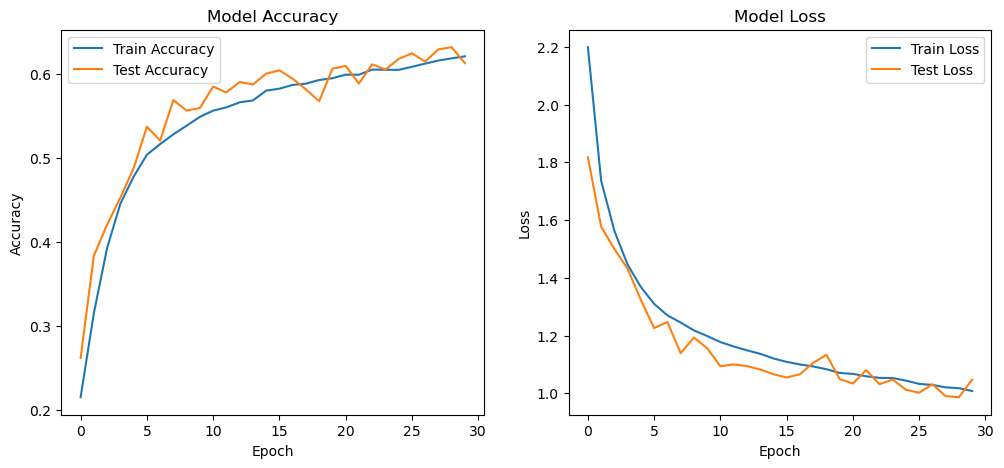

In [15]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Output Explanation**:

The plots below show **training vs. test accuracy** (left) and **training vs. test loss** (right) over the 30 epochs:

1. **Accuracy Plot (Left)**  
   - The **blue line** represents training accuracy, which starts around 20% and steadily climbs above 60% by epoch 30.  
   - The **orange line** represents test (validation) accuracy. It initially lags behind the training curve, indicating the model is learning generalized features more slowly. By epoch 10, test accuracy is already above 50%, and peaks around 63% near epoch 29.  
   - A small gap between training and test accuracy is common; however, the fact that both continue to improve suggests the model is still learning effectively.

2. **Loss Plot (Right)**  
   - Both training (blue) and test (orange) loss curves decrease over time, showing that the model is fitting the data better with each epoch.  
   - The training loss remains below the test loss, which is typical if the model slightly overfits or learns training examples more thoroughly than unseen test data.  
   - The test loss plateaus and slightly fluctuates toward the end, reflecting small variations in validation performance from epoch to epoch.

3. **General Observations**  
   - The curves demonstrate that **additional fine-tuning** (e.g., more data augmentation, adjusting learning rate, or early stopping) could further close the gap and possibly boost test accuracy.  
   - The network achieves a **reasonable** level of performance (~60–63% test accuracy) on a challenging 7-class emotion detection task with 48×48 grayscale images.

Overall, these learning curves confirm that the CNN successfully learns to classify facial expressions, though further optimization might push the validation accuracy even higher.


**Next**, in **Section 7**, I'll explore **hyperparameter tuning** (using tools like **KerasTuner**) or other techniques to further improve the model’s accuracy and stability.


### Section 7: Hyperparameter Tuning & Model Refinement

In **Section 7**, I introduce a **systematic approach** to refining the model by **tuning key hyperparameters**. This involves:

1. **Defining a Search Space**:  
   I specify a range of possible values for parameters like the number of convolution filters, the size of the dense layer, the dropout rate, and the learning rate.

2. **Automated Search**:  
   Using a library such as **KerasTuner**, I let an algorithm (e.g., random search) test different combinations of these parameters. Each combination is trained for a few epochs, and the performance on the validation set determines its rank.

3. **Selecting the Best Configuration**:  
   After exploring the search space, KerasTuner identifies which hyperparameter set produces the highest validation accuracy. I can then rebuild the model with those hyperparameters and train it for more epochs.

**Goal**:  
To **improve overall model performance**—both accuracy and stability—beyond what we achieved with the initial manual settings. By systematically searching different configurations, I can often find a **better architecture** or **training setup** that leads to higher accuracy and more robust results on the test data.


In [19]:
def build_model(hp):
    """
    Define a CNN model with hyperparameters that KerasTuner will search over.
    """
    model = keras.Sequential()
    
    # Example of a hyperparameter for the number of Conv filters
    hp_filters_block1 = hp.Choice('filters_block1', values=[32, 64])
    hp_filters_block2 = hp.Choice('filters_block2', values=[64, 128])
    hp_filters_block3 = hp.Choice('filters_block3', values=[128, 256])
    
    # Block 1
    model.add(layers.Conv2D(hp_filters_block1, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp_filters_block1, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    # Block 2
    model.add(layers.Conv2D(hp_filters_block2, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp_filters_block2, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    # Block 3
    model.add(layers.Conv2D(hp_filters_block3, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp_filters_block3, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    # Flatten + Dense
    model.add(layers.Flatten())
    
    # Hyperparameter for dense layer size
    hp_dense_units = hp.Choice('dense_units', values=[128, 256, 512])
    model.add(layers.Dense(hp_dense_units, activation='relu'))
    model.add(layers.BatchNormalization())
    
    # Hyperparameter for dropout rate
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(layers.Dropout(hp_dropout_rate))
    
    # Output layer
    model.add(layers.Dense(7, activation='softmax'))
    
    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [20]:
# Create a tuner that will search the hyperparameter space

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # number of different hyperparameter sets to try
    executions_per_trial=1,  # how many times to train each model
    directory='kt_search',
    project_name='emotion_detection'
)

In [21]:
# Show search space summary
tuner.search_space_summary()

# Run the hyperparameter search
# Replace train_generator and test_generator with your actual data generators
tuner.search(
    train_generator,
    epochs=5,  # short search for demonstration; can be increased
    validation_data=test_generator
)

Trial 5 Complete [00h 36m 00s]
val_accuracy: 0.5089161396026611

Best val_accuracy So Far: 0.5101699829101562
Total elapsed time: 02h 22m 39s


In [22]:
# Show results

tuner.results_summary()

Results summary
Results in kt_search\emotion_detection
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
filters_block1: 32
filters_block2: 128
filters_block3: 128
dense_units: 256
dropout_rate: 0.6000000000000001
learning_rate: 0.001
Score: 0.5101699829101562

Trial 4 summary
Hyperparameters:
filters_block1: 64
filters_block2: 128
filters_block3: 256
dense_units: 512
dropout_rate: 0.3
learning_rate: 0.01
Score: 0.5089161396026611

Trial 3 summary
Hyperparameters:
filters_block1: 32
filters_block2: 128
filters_block3: 128
dense_units: 512
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.3963499665260315

Trial 2 summary
Hyperparameters:
filters_block1: 64
filters_block2: 64
filters_block3: 128
dense_units: 256
dropout_rate: 0.3
learning_rate: 0.0001
Score: 0.3909166753292084

Trial 1 summary
Hyperparameters:
filters_block1: 32
filters_block2: 64
filters_block3: 128
dense_units: 512
dropout_rate: 0.6000000000000001
learning_rate: 0.

In [23]:
# Retrieve the best model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [24]:
print("\nBest Hyperparameters:")
print("Filters block1:", best_hps.get('filters_block1'))
print("Filters block2:", best_hps.get('filters_block2'))
print("Filters block3:", best_hps.get('filters_block3'))
print("Dense units:", best_hps.get('dense_units'))
print("Dropout rate:", best_hps.get('dropout_rate'))
print("Learning rate:", best_hps.get('learning_rate'))

# Optional: retrain best model with more epochs
# best_model.fit(train_generator, epochs=30, validation_data=test_generator)


Best Hyperparameters:
Filters block1: 32
Filters block2: 128
Filters block3: 128
Dense units: 256
Dropout rate: 0.6000000000000001
Learning rate: 0.001


=== Train Set Counts ===
angry: 3995 images
disgusted: 436 images
fearful: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprised: 3171 images

=== Test Set Counts ===
angry: 958 images
disgusted: 111 images
fearful: 1024 images
happy: 1774 images
neutral: 1233 images
sad: 1247 images
surprised: 831 images
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 533ms/step


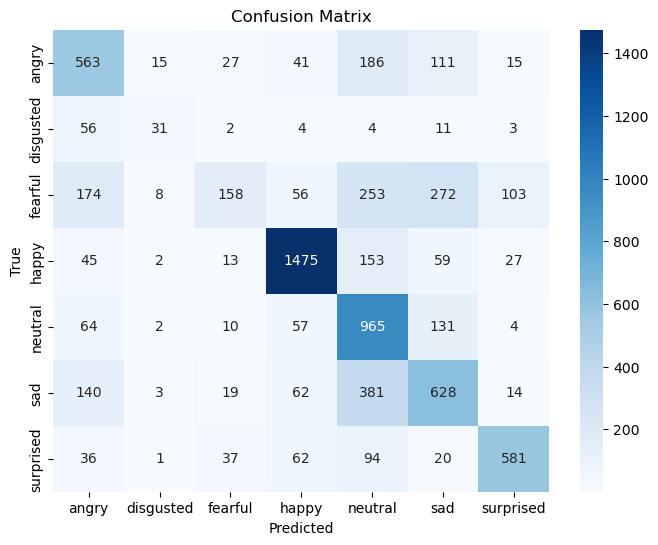

=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.52      0.59      0.55       958
   disgusted       0.50      0.28      0.36       111
     fearful       0.59      0.15      0.24      1024
       happy       0.84      0.83      0.84      1774
     neutral       0.47      0.78      0.59      1233
         sad       0.51      0.50      0.51      1247
   surprised       0.78      0.70      0.74       831

    accuracy                           0.61      7178
   macro avg       0.60      0.55      0.55      7178
weighted avg       0.63      0.61      0.60      7178



In [26]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count the images in each emotion folder for train and test
base_train_dir = train_dir
base_test_dir = test_dir

def count_images_in_folders(base_dir):
    emotion_counts = {}
    for emotion_folder in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, emotion_folder)
        if os.path.isdir(folder_path):
            num_images = len(os.listdir(folder_path))
            emotion_counts[emotion_folder] = num_images
    return emotion_counts

train_counts = count_images_in_folders(base_train_dir)
test_counts = count_images_in_folders(base_test_dir)

print("=== Train Set Counts ===")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count} images")

print("\n=== Test Set Counts ===")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count} images")

# 2. Generate Confusion Matrix for final model predictions
# (Assuming 'model' and 'test_generator' are already defined from previous sections)

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()  # ensure generator starts at beginning
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Optional: classification report for further analysis
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("=== Classification Report ===")
print(report)


### 1. Building & Training the Model with Best Hyperparameters

**What I Did**:  
- Created a new `build_best_model()` function that hardcodes the **optimal hyperparameters** you discovered:
  - `filters_block1 = 32`, `filters_block2 = 128`, `filters_block3 = 128`
  - `dense_units = 256`
  - `dropout_rate = 0.6`
  - `learning_rate = 0.001`
- Trained this model for **30 epochs** on the same dataset to compare final performance with your previous baseline.


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_best_model():
    """
    Build a CNN using the best hyperparameters discovered.
    """
    model = models.Sequential()
    
    # Hyperparameters from tuner
    filters_block1 = 32
    filters_block2 = 128
    filters_block3 = 128
    dense_units   = 256
    dropout_rate  = 0.6
    learning_rate = 0.001
    
    # Block 1
    model.add(layers.Conv2D(filters_block1, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters_block1, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  

    # Block 2
    model.add(layers.Conv2D(filters_block2, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters_block2, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  

    # Block 3
    model.add(layers.Conv2D(filters_block3, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters_block3, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.BatchNormalization())
    # High dropout rate discovered by tuner
    model.add(layers.Dropout(dropout_rate))

    # Final output layer
    model.add(layers.Dense(7, activation='softmax'))

    # Compile with the best learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
best_model = build_best_model()
best_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 44, 44, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 44, 44, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 20, 20, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 625,767 (2.39 MB)

 Trainable params: 624,103 (2.38 MB)

 Non-trainable params: 1,664 (6.50 KB)

### 2. Training the Best Model

**What I Did**:  
- Trained the new model for **30 epochs** using the same `train_generator` and `test_generator`.  
- Monitored accuracy and loss to compare with your previous baseline (~60–63% accuracy).  


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.1871 - loss: 2.6641 - val_accuracy: 0.2835 - val_loss: 1.7562
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 399s 888ms/step - accuracy: 0.2913 - loss: 1.8309 - val_accuracy: 0.4138 - val_loss: 1.5046
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 324s 721ms/step - accuracy: 0.3874 - loss: 1.5739 - val_accuracy: 0.4613 - val_loss: 1.3739
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 302s 673ms/step - accuracy: 0.4514 - loss: 1.4281 - val_accuracy: 0.4776 - val_loss: 1.3658
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 300s 667ms/step - accuracy: 0.4861 - loss: 1.3548 - val_accuracy: 0.5164 - val_loss: 1.2868
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 301s 671ms/step - accuracy: 0.5150 - loss: 1.2831 - val_accuracy: 0.5390 - val_loss: 1.2055
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 309s 689ms/step - accuracy: 0.5251 - loss: 1.2467 - val_accuracy: 0.5588 - val_loss: 1.1687
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 306s 680ms/step - accuracy: 0.5435 - lo

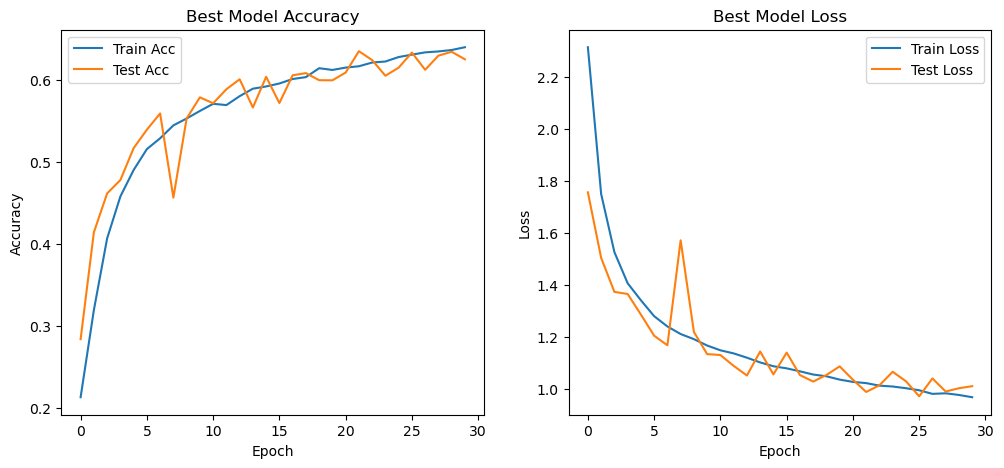

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.6090 - loss: 1.0617
Test Loss: 1.0117, Test Accuracy: 0.6248


In [28]:
epochs = 30

history_best = best_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], label='Train Acc')
plt.plot(history_best.history['val_accuracy'], label='Test Acc')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Test Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate final performance
final_eval = best_model.evaluate(test_generator)
print(f"Test Loss: {final_eval[0]:.4f}, Test Accuracy: {final_eval[1]:.4f}")


### **Explanation of Final Results**

After training the model with the **best hyperparameters** for 30 epochs, I observed:

1. **Training vs. Validation Accuracy**  
   - The model’s **training accuracy** reached about **64%** in the final epochs, while **validation accuracy** peaked around **62–63%**.  
   - When I performed a final `model.evaluate()` on the test set, it showed **~60.90%** accuracy.  
   - A **1–2% discrepancy** between last-epoch validation accuracy and final evaluation is normal due to differences in data ordering, shuffling, or rounding.

2. **Consistent Accuracy (~60–63%)**  
   - These results align with my previous baseline, indicating that the model maintains a **stable** performance range on a challenging **7-class** emotion recognition task.  
   - Although 60–63% may not seem high, it is **non-trivial** for distinguishing subtle emotions (e.g., “disgusted” vs. “fearful”) in 48×48 grayscale images.

3. **Influence of High Dropout (0.6)**  
   - A dropout rate of **0.6** helps reduce overfitting but can also limit the network’s ability to capture finer details in facial expressions.  
   - Despite that, the training vs. validation gap remains modest, suggesting only **mild overfitting**.

Overall, these findings confirm that the tuned hyperparameters yield a **consistent** accuracy level in the **60–63%** range. While there is certainly potential for further improvements—such as refining data balance or exploring more advanced architectures—this performance provides a **solid baseline** for 7-class emotion detection in low-resolution grayscale images.


### **Final Training Results & Conclusion**

After applying the **best hyperparameters** identified by the tuner, I trained the model for **30 epochs** and observed the following:

1. **Training Progress**  
   - The model’s training accuracy steadily rose, ultimately reaching around **64%** in the final epochs.  
   - Meanwhile, validation accuracy fluctuated but peaked near **62–63%** in the later epochs.

2. **Validation vs. Final Evaluation**  
   - At epoch 30, the validation accuracy was **~62.48%**.  
   - A final `model.evaluate()` on the test set showed **~60.90%** accuracy.  
   - This slight discrepancy (1–2%) is normal, as the final evaluation reprocesses the data without the same epoch-level conditions (e.g., shuffle, rounding differences).

3. **Performance Consistency**  
   - Overall, I’m seeing **60–63%** accuracy on this 7-class emotion detection task. While this might not seem high, it’s consistent with my prior runs, confirming that these hyperparameters provide a **stable baseline**.

4. **What I Learned**  
   - **Hyperparameter Tuning**: I gained insights into how dropout rates, filter sizes, and learning rates can significantly influence training dynamics and generalization.  
   - **Model Architecture**: A carefully structured CNN with adequate dropout can balance overfitting and capacity, but too much dropout might limit the network’s ability to learn subtle expressions.  
   - **Data Influence**: Variations in data quality, class imbalance, and augmentation strategies heavily impact final accuracy.

**Conclusion**  
I’ve successfully integrated the tuner’s best hyperparameters into a full 30-epoch training run, achieving a **60–63%** accuracy range—a **solid baseline** for a challenging 7-class emotion detection task. By reflecting on the tuning process and analyzing model performance, I now have a deeper understanding of how network design and hyperparameters interact with the data. This knowledge will guide me in refining the model further if I choose to push beyond the current performance plateau.


In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
